# Data Preparation for Predictive Modeling

- 거래데이터로부터 예측모델링을 위한 훈련, 테스트 데이터 생성

In [1]:
# 기본 라이브러리 로딩 및 사용자 정의함수 정의

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.polynomial import polyfit
import matplotlib.style as style 

import warnings
warnings.filterwarnings('ignore')


# define universally useful UDFs

# define random jitter
def rjitt(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev


# custom min max scaler
def mnmx_scl(vec):
    vec = (vec-vec.min())/(vec.max()-vec.min())
    return(vec)

def zrmx_scl(vec):
    vec = vec/vec.max()
    return(vec)

# to set data path
dataPath = 'https://github.com/stillxyxon/kma_Recsys2020/raw/master/'


# matplotlib 에서 한글을 표시하기 위한 설정
import matplotlib

font_name = matplotlib.font_manager.FontProperties(
                fname="c:/Windows/Fonts/malgun.ttf"  # 윈도우즈의 한글 폰트 위치를 지정
            ).get_name()
matplotlib.rc('font', family=font_name) # 한글 표시 가능하도록 폰트 지정 
matplotlib.rcParams['axes.unicode_minus'] = False #  음수를 나타내는 '-' 부호가 정상 표시되도록

### The Dataset : B2B Online Shopping Transactions

- A publicly availble dataset of B2B online retailer
- Data source : https://archive.ics.uci.edu/ml/datasets/online+retail
- Most of the customers are wholesalers in Europe

In [2]:
# load dataset

# tr01a = tr01.head(270955)
# tr01a.to_csv(dataPath + 'onlineRetail_A.csv', index=False)
print(dataPath + 'onlineRetail_A.csv')

tr01a = pd.read_csv(dataPath + 'onlineRetail_A.csv')

# tr01b = tr01.tail(270954)
# tr01b.to_csv(dataPath + 'onlineRetail_B.csv', index=False)
tr01b = pd.read_csv(dataPath + 'onlineRetail_B.csv')

# to bypass github upload size limitation, read pre-split datasets and merge
tr01 = pd.concat([tr01a, tr01b], axis=0)
print('shape of df : ', tr01.shape)

# include only valid transactions (i.e. exclude returns and cancels )
# 수량이 음수이거나 단가가 음수면 취소/반품 성격
tr01 = tr01[(tr01.Quantity>0) & tr01.UnitPrice>0]

SCdesc_mast = tr01[['StockCode','Description']].drop_duplicates()

print('num of unique customer IDs :', len(tr01.CustomerID.unique()))
tr01.head()

https://github.com/stillxyxon/kma_Recsys2020/raw/master/onlineRetail_A.csv
shape of df :  (541909, 8)
num of unique customer IDs : 4339


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom


In [3]:
# sampling 0.1K customers
# 눈으로 확인하려고 무작위 백명을 추출

from random import sample 

np.array(sample(list(tr01.CustomerID),100))

# CustomerID 변수값이 missing인 경우 다수 존재 == anonymous users?

array([   nan, 17974., 14606.,    nan, 14146., 14505., 16143., 15311.,
       16353.,    nan,    nan, 15622.,    nan, 18230., 16746., 16558.,
       16049., 14246., 16669., 15167., 15058., 18212.,    nan, 18109.,
       13376., 14911., 17980., 18225., 14606., 17965., 17377., 17306.,
       17381., 14052., 14585., 14505., 16839.,    nan, 13363., 17690.,
       13632., 14729., 15730.,    nan, 13983., 16710.,    nan, 16898.,
       14459., 15498., 15856., 12682., 16504., 14128., 14669., 14191.,
       14096., 15000.,    nan, 13709., 13230., 13032., 17841., 16816.,
       17757., 13694., 13021., 18109., 17419., 14456., 14930.,    nan,
       14060.,    nan, 14562.,    nan, 13097., 17757.,    nan,    nan,
          nan, 16115., 12433., 14841.,    nan, 17374.,    nan, 17769.,
       14587.,    nan, 17651., 15018.,    nan,    nan,    nan, 16790.,
       18024., 12678., 15544., 17790.])

- 타겟마케팅을 위해 고객을 분석하는 것이라면 식별된 고객만으로 한정하는 것이 불가피

In [4]:
# ID 없는 건 제외한 df 생성

tr02 = tr01[tr01.CustomerID.notnull()]
tr01.shape, tr02.shape

((530106, 8), (397884, 8))

In [5]:
# 데이터 기간 확인
tr02.InvoiceDate.min(), tr02.InvoiceDate.max()

('2010-12-01 10:03', '2011-12-09 9:46')

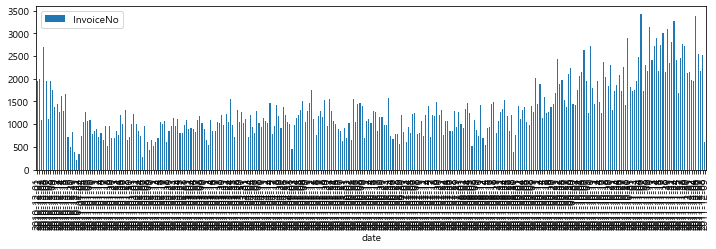

In [6]:
# 일자별 건수 확인

tr02['date'] = tr02.InvoiceDate.str.slice(0,10) # 시간은 제외하고 일자만 string 컬럼으로

# 막대챠트 생성
tr02[['date','InvoiceNo']].groupby('date').count().plot(kind='bar', figsize=(12,3))

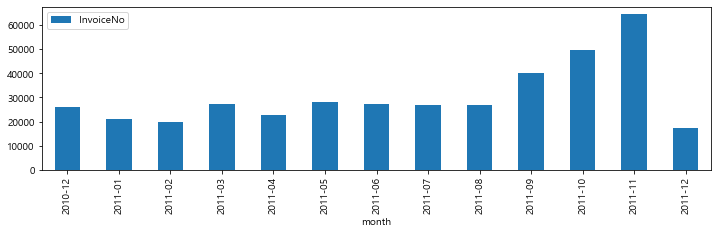

In [7]:
# 월별 건수 확인

tr02['month'] = tr02.InvoiceDate.str.slice(0,7) # 월만 string 컬럼으로

# 막대챠트 생성
tr02[['month','InvoiceNo']].groupby('month').count().plot(kind='bar', figsize=(12,3))

- [검토] 2011년 12월은 9일 까지만 데이터가 존재 --> 1년에 약간 여유를 두고 추출한 것이라면 12개월~1개월 형태로 예측모델을 만들기는 부적합할 것
- 마지막달이 1개월이 안되므로

## preparing dataset for RFM style modeling

### separate predictor and target time period
- 예측모델링 형태에서는 독립변수와 종속변수 target의 기간이 다름
- 독립변수와 종속변수를 각기 다른 기간의 데이터로 생성해야함
- RFM의 구조는 예측모델 형태

In [8]:
# Description in ['Manual', 'POSTAGE', 'DOTCOM POSTAGE'] 제외 필요
tr02 = tr02[~tr02.Description.isin(['Manual', 'POSTAGE', 'DOTCOM POSTAGE'])]

In [9]:
# subset data to prepare predictor set

tr02a = tr02[(tr02.date>='2010-12-01') & (tr02.date<='2011-11-30')] #  12개월분 데이터 포함
tr02a.tail()

# 무조건 1년단위로 채워야 하는 것은 아니지만, 
# 계절성이 흔히 큰 영향을 주므로 1년 채우는 것이 유용한 경우 많음

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,month
245409,579885,85034C,3 ROSE MORRIS BOXED CANDLES,4,2011-11-30 17:37,1.25,15444.0,United Kingdom,2011-11-30,2011-11
245410,579885,21742,LARGE ROUND WICKER PLATTER,2,2011-11-30 17:37,5.95,15444.0,United Kingdom,2011-11-30,2011-11
245411,579885,23084,RABBIT NIGHT LIGHT,6,2011-11-30 17:37,2.08,15444.0,United Kingdom,2011-11-30,2011-11
245412,579885,21257,VICTORIAN SEWING BOX MEDIUM,1,2011-11-30 17:37,7.95,15444.0,United Kingdom,2011-11-30,2011-11
245413,579885,21259,VICTORIAN SEWING BOX SMALL,1,2011-11-30 17:37,5.95,15444.0,United Kingdom,2011-11-30,2011-11


In [10]:
# create a predictor named Frequency
# 동일한 날짜에 여러 번 거래가 있어도 하나로 간주 (=하루)
# Frequency는 거래일의 수 개념으로 정의

trFrq = tr02a[['CustomerID', 'date']].drop_duplicates().groupby('CustomerID').count().reset_index()
trFrq.columns = ['CustomerID', 'Frq']
trFrq.head()

,CustomerID,Frq
0,12346.0,1
1,12347.0,6
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [11]:
# Monetary - 전체기간 금액 합계

trAMT01 = tr02a[['CustomerID', 'Quantity', 'UnitPrice']]
# 수량과 단가를 곱해서 record 별 (= order detail) 금액 산출
trAMT01['Amount'] = tr02a.Quantity * tr02a.UnitPrice

# 고객별 금액 집계
trAMT02 = trAMT01[['CustomerID', 'Amount']].groupby('CustomerID').sum().reset_index()
trAMT02.columns = ['CustomerID', 'AMT']
trAMT02.head()

,CustomerID,AMT
0,12346.0,77183.60
1,12347.0,4085.18
2,12348.0,1437.24
3,12349.0,1457.55
4,12350.0,294.40


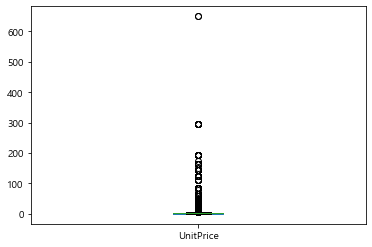

4989      295.0
82768     295.0
118769    295.0
171178    295.0
32484     295.0
205759    295.0
51636     295.0
133994    295.0
222682    649.5
222680    649.5
Name: UnitPrice, dtype: float64

In [12]:
# 단가의 분포 확인
tr02a.UnitPrice.plot(kind='box')
plt.show()

# 단가가 매우 큰 경우 (outlier?) 확인
tr02a.UnitPrice.sort_values().tail(10)

In [13]:
tr02a[tr02a.UnitPrice>300].tail(10)

# 우편 관련된 것들과 처리 관련된 것 등 상품으로 볼 수 없는 항목들 다수 = 분석 제외 대상
# ['Manual', 'POSTAGE', 'DOTCOM POSTAGE']

# ==> 처음으로 돌아가서 해당 데이터를 제외한 후 전체 집계 재실행!

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,month
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28,649.5,15098.0,United Kingdom,2011-06-10,2011-06
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33,649.5,15098.0,United Kingdom,2011-06-10,2011-06


In [14]:
# 집계된 RFM 변수들을 담을 고객리스트 테이블 생성
dfRFM = tr02a[['CustomerID']].drop_duplicates()
# dfRFM.head()

# 하나씩 R, F, M 결합
dfRFM = dfRFM.merge(trFrq, on='CustomerID', how='left')
dfRFM = dfRFM.merge(trAMT02, on='CustomerID', how='left')
dfRFM.head()

,CustomerID,Frq,AMT
0,17850.0,2,5391.21
1,13047.0,7,3232.59
2,12583.0,14,6064.61
3,13748.0,4,948.25
4,15100.0,3,876.00


any missing? 0


Text(0, 0.5, 'Amount')

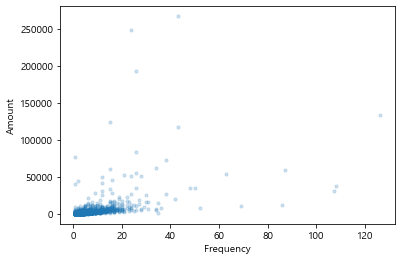

In [15]:
# check if any missing
print('any missing?', dfRFM.isna().any().sum())

# check distribution
plt.scatter(dfRFM.Frq, dfRFM.AMT, alpha=0.2, s=10)
plt.xlabel('Frequency')
plt.ylabel('Amount')

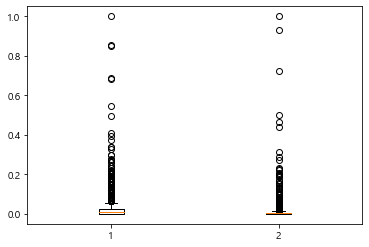

In [16]:
# check if any outlier

plt.boxplot([mnmx_scl(dfRFM.Frq), mnmx_scl(dfRFM.AMT)]);

# 스케일링 없이 그려보면??

Text(0, 0.5, 'Amount')

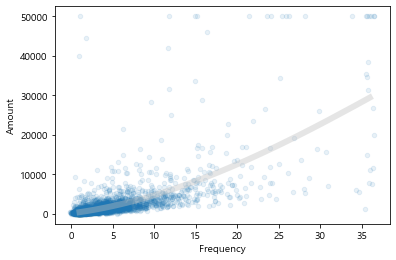

In [17]:
# 임시로 금액을 대체한 후 분포 확인

dfRFM1 = dfRFM
dfRFM1['AMT'] = np.where(dfRFM1.AMT>50000, 50000, dfRFM1.AMT)
dfRFM1['Frq'] = np.where(dfRFM1.Frq>36, 36, dfRFM1.Frq)

plt.scatter(rjitt(dfRFM1.Frq), dfRFM1.AMT, alpha=0.1, s=20)

# 다항회귀분석 (polynomial regression) 보조선 추가
plt.plot(np.unique(dfRFM1.Frq), np.poly1d(np.polyfit(dfRFM1.Frq, dfRFM1.AMT, 3))(np.unique(dfRFM1.Frq)), 
         color='silver', linewidth=6, alpha=0.4, )
plt.xlabel('Frequency')
plt.ylabel('Amount')

In [18]:
# Recency 계산 - 마지막 거래가 있었던 것이 얼마나 떨어져 있는가
# Recency는 still active? 를 나타내는 변수


tr02ar = tr02a[['CustomerID', 'date']]
# 계산 가능하도록 date 타입으로 변경
tr02ar['dated'] = pd.to_datetime(tr02ar['date'])
tr02ar = tr02ar.drop_duplicates()

# 고객별 마지막 거래일 산출 - 마지막 날은 가장 큰 날짜값
tr02ar = tr02ar.groupby('CustomerID').max().reset_index()
print(tr02ar.shape)
tr02ar.tail()

(4294, 3)


,CustomerID,date,dated
4289,18280.0,2011-03-07,2011-03-07
4290,18281.0,2011-06-12,2011-06-12
4291,18282.0,2011-08-05,2011-08-05
4292,18283.0,2011-11-30,2011-11-30
4293,18287.0,2011-10-28,2011-10-28


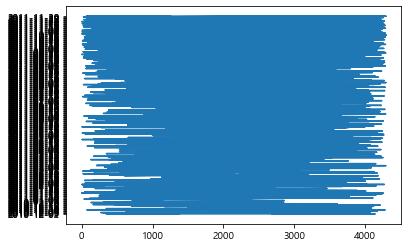

In [19]:
# 마지막 거래일 분포
# string 타입인 경우라면 
plt.plot(tr02ar.drop_duplicates().date.sort_values())

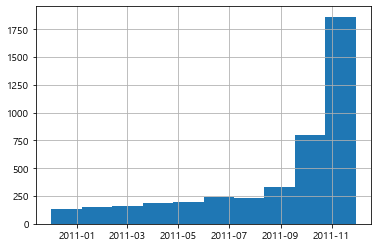

In [20]:
# 마지막날이 최근에 가까운 경우가 많은 것이 당연

tr02ar.dated.hist()

In [21]:
# 기간의 마지막과 고객별 마지막 거래한 날과의 거리 계산

tr02ar['lastday'] = '2011-12-01' 
# 전날을 기준으로 삼으면 마지막날 구매시 -1
tr02ar['lastday'] = pd.to_datetime(tr02ar['lastday'])

tr02ar['recency'] = tr02ar['dated'] - tr02ar['lastday']
# 음수가 되도록 한 이유는 간격이 클 수록 미래 구매가능성이 낮을 것으로 예상되기 때문
# 금액과 빈도와는 방향성이 다름
tr02ar['recency'] = (tr02ar['recency'] / np.timedelta64(1, 'D')).astype(int)
tr02ar.head()

,CustomerID,date,dated,lastday,recency
0,12346.0,2011-01-18,2011-01-18,2011-12-01,-317
1,12347.0,2011-10-31,2011-10-31,2011-12-01,-31
2,12348.0,2011-09-25,2011-09-25,2011-12-01,-67
3,12349.0,2011-11-21,2011-11-21,2011-12-01,-10
4,12350.0,2011-02-02,2011-02-02,2011-12-01,-302


Text(0.5, 0, 'recency')

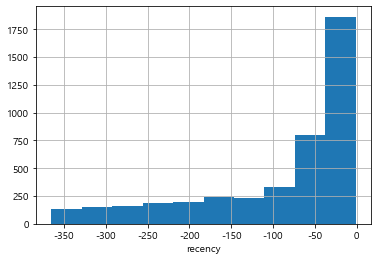

In [22]:
tr02ar.recency.hist()
plt.xlabel('recency')

In [23]:
# recency 까지 결합해서 RFM predictor set 완성

dfRFM = dfRFM.merge(tr02ar[['CustomerID','recency']], on='CustomerID', how='left')
dfRFM.head()

,CustomerID,Frq,AMT,recency
0,17850.0,2,5391.21,-364
1,13047.0,7,3232.59,-48
2,12583.0,14,6064.61,-10
3,13748.0,4,948.25,-87
4,15100.0,3,876.00,-325


In [24]:
# target variable 생성

#  다음 1개월분 데이터 포함
tr02b = tr02[(tr02.date>='2011-12-01') & (tr02.date<='2012-12-31')] 
# 참고: 실제 데이터에는 한 달치 데이터가 다 존재하지는 않음

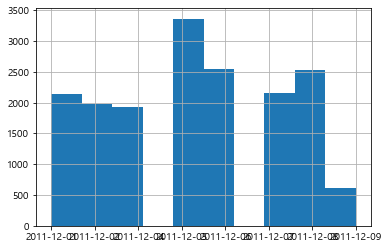

In [25]:
tr02b.date.hist()

In [26]:
# 기간이 달라졌으나 금액집계는 같은 방식으로
# 수량에 단가를 곱한 후 고객별 합계 생성

trAMTb01 = tr02b[['CustomerID', 'Quantity', 'UnitPrice']]
trAMTb01['Amount'] = tr02b.Quantity * tr02b.UnitPrice
trAMTb02 = trAMTb01[['CustomerID', 'Amount']].groupby('CustomerID').sum().reset_index()
trAMTb02.columns = ['CustomerID', 'AMT']
trAMTb02.head()

,CustomerID,AMT
0,12347.0,224.82
1,12358.0,523.20
2,12362.0,475.04
3,12364.0,295.32
4,12367.0,150.90


In [27]:
# 독립변수만 존재하는 df에 타겟 추가

trAMTb02.columns = ['CustomerID', 'AMTnm']
dfRFM = dfRFM.merge(trAMTb02, on='CustomerID', how='left')
dfRFM.head()

,CustomerID,Frq,AMT,recency,AMTnm
0,17850.0,2,5391.21,-364,NaN
1,13047.0,7,3232.59,-48,NaN
2,12583.0,14,6064.61,-10,640.77
3,13748.0,4,948.25,-87,NaN
4,15100.0,3,876.00,-325,NaN


In [28]:
# 다수의 NaN 값들은 해당기간 거래가 없었다는 의미이므로
# 금액을 0으로 대체

dfRFM.AMTnm = np.where(dfRFM.AMTnm.isna(), 0, dfRFM.AMTnm)
dfRFM.head()

# CustomerID should be a string column

,CustomerID,Frq,AMT,recency,AMTnm
0,17850.0,2,5391.21,-364,0.00
1,13047.0,7,3232.59,-48,0.00
2,12583.0,14,6064.61,-10,640.77
3,13748.0,4,948.25,-87,0.00
4,15100.0,3,876.00,-325,0.00


In [29]:
# 정수형태의 문자열로 변경

dfRFM.CustomerID = dfRFM.CustomerID.astype(float).astype(int).astype(str)
dfRFM.head()

,CustomerID,Frq,AMT,recency,AMTnm
0,17850,2,5391.21,-364,0.00
1,13047,7,3232.59,-48,0.00
2,12583,14,6064.61,-10,640.77
3,13748,4,948.25,-87,0.00
4,15100,3,876.00,-325,0.00


In [30]:
# check if any missing again

dfRFM.isna().any().sum()

0

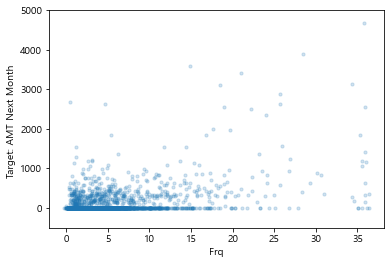

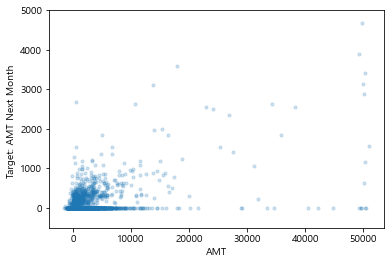

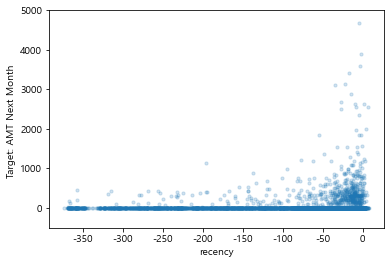

In [31]:
predictors = ['Frq','AMT', 'recency']

for x in predictors:
    plt.scatter(rjitt(dfRFM[x]), dfRFM.AMTnm, alpha=0.2, s=10)
    plt.xlabel(x)
    plt.ylabel('Target: AMT Next Month ')
    # 너무 큰 값들은 무시하고 다수의 패턴을 보기 위해 영역 한정
    plt.ylim(-500,5000)
    plt.show()

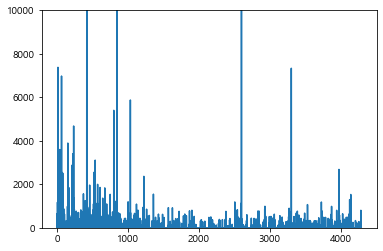

In [32]:
plt.plot(dfRFM.AMTnm)
plt.ylim(0,10000) # outlier로 보이는 영역을 무시하고 출력
plt.show()

In [33]:
np.corrcoef(dfRFM.Frq, dfRFM.AMTnm)[0,1], np.corrcoef(dfRFM.AMT, dfRFM.AMTnm)[0,1]

(0.06018233264050521, 0.0917041331223569)

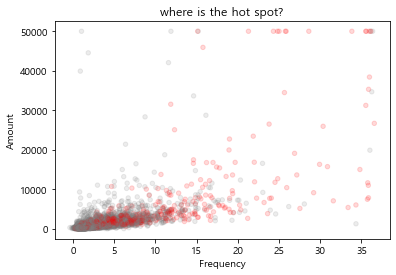

In [34]:
colors1 = ['red' if x>100 else 'grey' for x in dfRFM.AMTnm]
plt.scatter(rjitt(dfRFM.Frq), dfRFM.AMT, 
            alpha=0.15, s=20,
           color=colors1)
plt.title('where is the hot spot?')
plt.xlabel('Frequency')
plt.ylabel('Amount');

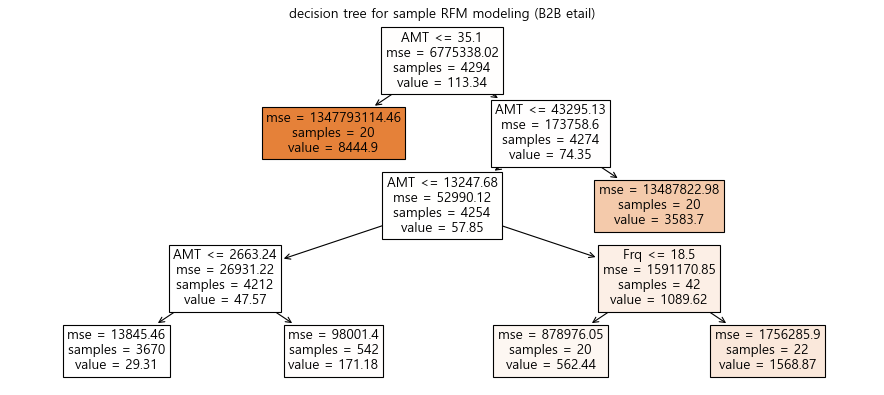

In [35]:
# use decision tree for visual inspection 

from sklearn.tree import DecisionTreeRegressor 
from sklearn import tree

clf = DecisionTreeRegressor(max_depth = 4, min_samples_leaf=20,
                             random_state = 0)
features = ['Frq', 'AMT', 'recency']
dt1 = clf.fit(dfRFM[features], dfRFM.AMTnm)

# plotting tree using sklearn (i.e. not using GraphViz)
# GraphViz 를 사용하는 방법이 좀 더 깔끔한 결과를 주지만
# 설정 오류가 잦아서 오류시엔 sklearn plot_tree 로

plt.figure(figsize=(14,6), dpi=80)
tree.plot_tree(dt1, feature_names=features, 
               filled=True, fontsize=12, precision=2)

plt.title('decision tree for sample RFM modeling (B2B etail)');

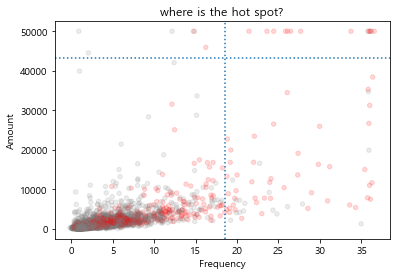

In [36]:
colors1 = ['red' if x>100 else 'grey' for x in dfRFM.AMTnm]
plt.scatter(rjitt(dfRFM.Frq), dfRFM.AMT, 
            alpha=0.15, s=20,
           color=colors1)
plt.title('where is the hot spot?')
plt.xlabel('Frequency')
plt.ylabel('Amount')
plt.axvline(18.5, linestyle='dotted')
plt.axhline(43295, linestyle='dotted')

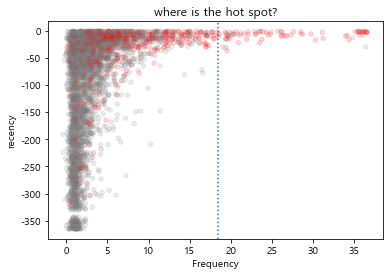

('correlation : ', 0.35233708071124603)

In [37]:
colors1 = ['red' if x>100 else 'grey' for x in dfRFM.AMTnm]
plt.scatter(rjitt(dfRFM.Frq), dfRFM.recency, 
            alpha=0.15, s=20,
           color=colors1)
plt.title('where is the hot spot?')
plt.xlabel('Frequency')
plt.ylabel('recency')
plt.axvline(18.5, linestyle='dotted')
plt.show()

'correlation : ', np.corrcoef(dfRFM.Frq, dfRFM.recency)[0,1]

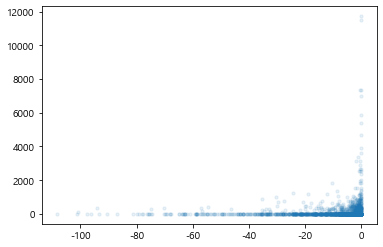

In [38]:
tmpdf = dfRFM[(dfRFM.AMTnm<100000) & (dfRFM.Frq > 2)]
plt.scatter((tmpdf.recency / tmpdf.Frq), tmpdf.AMTnm,
           s=10, alpha=0.1)

### Filtering out Irrelevant Records

In [39]:
tr02[['InvoiceNo', 'Description']].groupby('Description').count().sort_values('InvoiceNo', ascending=False).head(20)

,InvoiceNo
Description,
WHITE HANGING HEART T-LIGHT HOLDER,2028
REGENCY CAKESTAND 3 TIER,1723
JUMBO BAG RED RETROSPOT,1618
ASSORTED COLOUR BIRD ORNAMENT,1408
PARTY BUNTING,1396
LUNCH BAG RED RETROSPOT,1316
SET OF 3 CAKE TINS PANTRY DESIGN,1159
LUNCH BAG BLACK SKULL.,1105
PACK OF 72 RETROSPOT CAKE CASES,1068


In [40]:
# POSTAGE 우편비는 상품으로 볼 수 없다면 ==> 분석용 계산에서 무시

tr02 = tr02[tr02.Description !='POSTAGE']

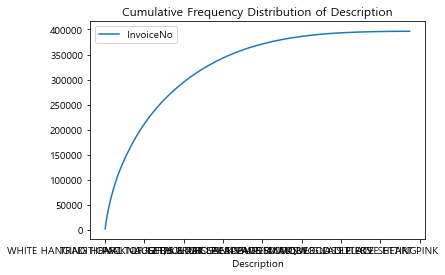

In [41]:
tr02[['InvoiceNo', 'Description']].groupby('Description').count().sort_values('InvoiceNo', ascending=False).cumsum().plot()
plt.title('Cumulative Frequency Distribution of Description')
plt.show()

### 추가적인 변수 생성 연습
- 최근 3개월 중 거래한 개월 수는?
- 최근 6개월 중 월별로 100 이상 금액을 거래한 개월 수는?
- 월별 금액의 변동성은?
- 총 구매한 Description의 종류 수는?
- [타겟변경] 예측대상 기간에 2일 이상 거래한 경우를 1로 (=Classification)

In [42]:
# 월별 금액의 변동성

tr02aflc = tr02a[['CustomerID', 'month', 'Quantity', 'UnitPrice']] # get fluctuation
tr02aflc['Amount'] = tr02aflc.Quantity * tr02aflc.UnitPrice

# 고객별 월별 집계 생성
tr02aflc1 = tr02aflc[['CustomerID', 'month','Amount']].groupby(['CustomerID', 'month']).sum().reset_index()
tr02aflc1.head()
# Issue: 고객별로 거래가 없던 월은 record 자체가 없음

,CustomerID,month,Amount
0,12346.0,2011-01,77183.60
1,12347.0,2010-12,711.79
2,12347.0,2011-01,475.39
3,12347.0,2011-04,636.25
4,12347.0,2011-06,382.52


In [43]:
# 모든 고객에 대해 모든 월의 조합 테이블 먼저 생성
from itertools import product
    
tr02aflc0 = pd.DataFrame(list(product(tr02aflc.CustomerID.drop_duplicates(), tr02aflc.month.drop_duplicates())), 
              columns=['CustomerID', 'month'])
tr02aflc0.head(20)

,CustomerID,month
0,17850.0,2010-12
1,17850.0,2011-01
2,17850.0,2011-02
3,17850.0,2011-03
4,17850.0,2011-04
5,17850.0,2011-05
6,17850.0,2011-06
7,17850.0,2011-07
8,17850.0,2011-08
9,17850.0,2011-09


In [44]:
tr02aflc0 = tr02aflc0.merge(tr02aflc1, on=['CustomerID','month'], how='left')
tr02aflc0.head()

,CustomerID,month,Amount
0,17850.0,2010-12,5391.21
1,17850.0,2011-01,NaN
2,17850.0,2011-02,NaN
3,17850.0,2011-03,NaN
4,17850.0,2011-04,NaN


In [45]:
# fill in missing values

tr02aflc0['Amount'] = np.where(tr02aflc0['Amount'].isna(), 0, tr02aflc0['Amount'])
tr02aflc0.head()

,CustomerID,month,Amount
0,17850.0,2010-12,5391.21
1,17850.0,2011-01,0.00
2,17850.0,2011-02,0.00
3,17850.0,2011-03,0.00
4,17850.0,2011-04,0.00


In [46]:
tr02aflc2 = tr02aflc0[['CustomerID','Amount']].groupby('CustomerID').std().reset_index()
# change column name to std of amount
tr02aflc2.head()

,CustomerID,Amount
0,12346.0,22280.986119
1,12347.0,416.744483
2,12348.0,206.479662
3,12349.0,420.758442
4,12350.0,84.985960


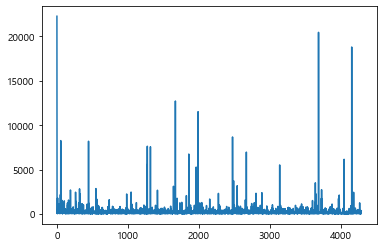

In [47]:
tr02aflc2.columns = ['CustomerID','AmountSTD']
tr02aflc2.AmountSTD.plot()

# we better use CV over std()  변동계수 CV = 표준편차/평균

In [48]:
tr02aflc3 = tr02aflc0[['CustomerID','Amount']].groupby('CustomerID').mean().reset_index()
tr02aflc3.columns = ['CustomerID','AmountMean']
# change column name to std of amount
tr02aflc2 = tr02aflc2.merge(tr02aflc3, on='CustomerID',  how='left')
# CV : Coefficent of Variance
tr02aflc2['AmountCV'] = tr02aflc2.AmountSTD/tr02aflc2.AmountMean
tr02aflc2.head()

,CustomerID,AmountSTD,AmountMean,AmountCV
0,12346.0,22280.986119,6431.966667,3.464102
1,12347.0,416.744483,340.431667,1.224165
2,12348.0,206.479662,119.770000,1.723968
3,12349.0,420.758442,121.462500,3.464102
4,12350.0,84.985960,24.533333,3.464102


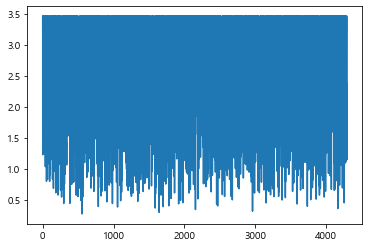

In [49]:
tr02aflc2.AmountCV.plot() # STD scaled consider Mean

In [50]:
# data type 통일
tr02aflc2.CustomerID = tr02aflc2.CustomerID.astype(float).astype(int).astype(str)

dfRFM = dfRFM.merge(tr02aflc2[['CustomerID', 'AmountCV']], on='CustomerID', how='left')
print(dfRFM.isna().any().sum())
dfRFM.head()

0


,CustomerID,Frq,AMT,recency,AMTnm,AmountCV
0,17850,2,5391.21,-364,0.00,3.464102
1,13047,7,3232.59,-48,0.00,0.903975
2,12583,14,6064.61,-10,640.77,0.609049
3,13748,4,948.25,-87,0.00,1.883540
4,15100,3,876.00,-325,0.00,2.794800


(0.0, 5000.0)

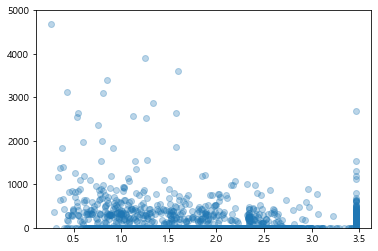

In [51]:
plt.scatter(dfRFM.AmountCV, dfRFM.AMTnm, alpha=0.3)
plt.ylim(0,5000)

# 변동성이 작을수록 다음 달 금액이 큰 관계

In [52]:
# 다른 변수들과 변동성간의 상관관계 확인

dfRFM[1::].corr()

,Frq,AMT,recency,AMTnm,AmountCV
Frq,1.000000,0.672886,0.352421,0.060180,-0.731119
AMT,0.672886,1.000000,0.193215,0.091721,-0.396893
recency,0.352421,0.193215,1.000000,0.002076,-0.486158
AMTnm,0.060180,0.091721,0.002076,1.000000,-0.015788
AmountCV,-0.731119,-0.396893,-0.486158,-0.015788,1.000000


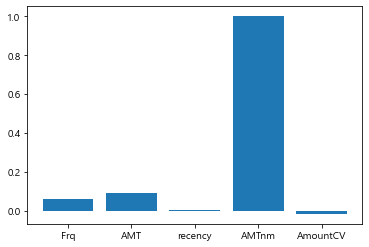

In [53]:
plt.bar(dfRFM[1::].corr().index, dfRFM[1::].corr()['AMTnm']);

In [54]:
# 특정 컬럼명 한 두개만 바꿔야 한다면 rename 으로 해당 컬럼을 변경

# dfRFM = dfRFM.rename(columns={"recency": "Receny"})
# dfRFM = dfRFM.rename(columns={"Rececny": "receny"})
# dfRFM = dfRFM.rename(columns={"receny": "recency"})
dfRFM.head()

,CustomerID,Frq,AMT,recency,AMTnm,AmountCV
0,17850,2,5391.21,-364,0.00,3.464102
1,13047,7,3232.59,-48,0.00,0.903975
2,12583,14,6064.61,-10,640.77,0.609049
3,13748,4,948.25,-87,0.00,1.883540
4,15100,3,876.00,-325,0.00,2.794800
